<a href="https://colab.research.google.com/github/100rab-S/Fun-With-MNIST/blob/main/MNIST-4/V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cd /content/drive/MyDrive/Fun With MNIST/MNIST-4(Object Detection)

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Input, Lambda, Flatten
from tensorflow.image import draw_bounding_boxes
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MultiLabelBinarizer

import logging  
import os

In [ ]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   # Authenticates the Colab machine and also the TPU using your
#   # credentials so that they can access your private GCS buckets.
#   auth.authenticate_user()

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.74.208.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.74.208.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
batch_size = 64
BATCH_SIZE = batch_size * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

In [ ]:
# BATCH_SIZE = 128

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


6


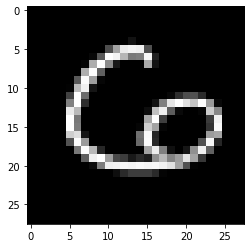

In [ ]:
def display_random_digit():
    random = np.random.randint(len(X_train))
    random_image = X_train[random]
    plt.imshow(random_image, cmap = 'gray')
    print(y_train[random])

display_random_digit()

In [ ]:
def print_shape():
    print('Shape of the training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nShape of the test dataset:')
    print(X_test.shape, y_test.shape)

print_shape()

Shape of the training dataset:
(60000, 28, 28) (60000,)

Shape of the test dataset:
(10000, 28, 28) (10000,)


In [ ]:
X_train = np.reshape(X_train, (30000, 2, 28, 28))/255.
y_train = np.reshape(y_train, (30000, 2,))
X_test = np.reshape(X_test, (5000, 2, 28, 28))/255.
y_test = np.reshape(y_test, (5000, 2,))

print_shape()

Shape of the training dataset:
(30000, 2, 28, 28) (30000, 2)

Shape of the test dataset:
(5000, 2, 28, 28) (5000, 2)


In [ ]:
ml = MultiLabelBinarizer()
ml.fit([tuple(np.unique(y_train))])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [ ]:
def preprocess_dataset(images, labels):
    '''
    This function randomly places 2 28*28 image in 100*100 canvas and also saves the bounding box co-ordinates.
    '''
    w, h = images[0][0].shape, images[0][0].shape
    image1 = images[0]
    image2 = images[1]
    ans1 = labels[0]
    ans2 = labels[1]
    desired_output = 100

    canvas = np.zeros((desired_output, desired_output))

    while(True):
        rand_width1, rand_height1 = np.random.randint(72, size=2) # 100-28 = 72 x_min, y_min
        rand_width2, rand_height2 = np.random.randint(72, size = 2)
        if (abs(rand_width1 - rand_width2)>=30 or abs(rand_height1 - rand_height2) >= 30):  # avoid collision of images
            break

    div = float(desired_output) # to normalize the values
    boxes = [[rand_width1/div, rand_height1/div, (rand_width1+28)/div, (rand_height1+28)/div],
           [rand_width2/div, rand_height2/div, (rand_width2+28)/div, (rand_height2+28)/div]]   

    canvas[rand_width1 : rand_width1+28, rand_height1 : rand_height1+28] = image1
    canvas[rand_width2 : rand_width2+28, rand_height2 : rand_height2+28] = image2

    canvas = np.expand_dims(canvas, axis = -1)
    boxes = np.array(boxes, dtype = float)

    y = [(ans1, ans2)]
    label = ml.transform(y).flatten()

    return canvas, (label, boxes)

def display_bound_boxes(images, boxes, labels):
    '''
    Displays images with bounding boxes. Accepts 4D images, 3D boxes, 2D labels
    '''
    images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images)).numpy()
    color = np.array([[1.0, 0.0, 0.0], [2.0, 0.0, 0.0]])

    images = draw_bounding_boxes(images, boxes, colors=color)

    
    nrows = np.ceil(len(images)/10).astype(int)
    fig, axes = plt.subplots(nrows, 10, figsize = (20, 3*nrows), sharex = True, sharey=True)
    for ax, image, label in zip(axes.ravel(), images, labels):
        # image = tf.cast(image*255, tf.uint8) # to remove the warnings but the colour of image changes
        label = label.argsort()[-2:][::-1]
        label = str(label[0]) + ', ' + str(label[1])

        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)

        ax.imshow(image, cmap = 'gray')
        ax.set_title(label)

        logger.setLevel(old_level)


def reshaping(X, Y):
    ans = []
    leng = X.shape[0]
    for x, y in zip(X, Y):
        ans.append(preprocess_dataset(x, y))
    ans = np.asarray(ans)
    ans = ans.flatten('F')
    imgs = ans[:leng]
    ys = ans[leng:]

    imgs = np.concatenate(imgs).reshape((leng, 100, 100, 1)).astype('float32')
    print('Images shape: ', imgs.shape)

    labels = np.array([list(l[0]) for l in ys], dtype = 'float32')
    print('Labels shape: ', labels.shape)

    boxes = []
    for i in range(len(ys)):
        boxes.append(ys[i][1])

    boxes = [[item for subsublist in box for item in subsublist] for box in boxes]
    boxes = np.array(boxes).astype('float32')
    print('Boxes shape: ', boxes.shape)

    return imgs, (labels, boxes)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(reshaping(X_train, y_train))
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(-1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Images shape:  (30000, 100, 100, 1)
Labels shape:  (30000, 10)
Boxes shape:  (30000, 8)


In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices(reshaping(X_test, y_test))
valid_dataset = valid_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(-1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Images shape:  (5000, 100, 100, 1)
Labels shape:  (5000, 10)
Boxes shape:  (5000, 8)


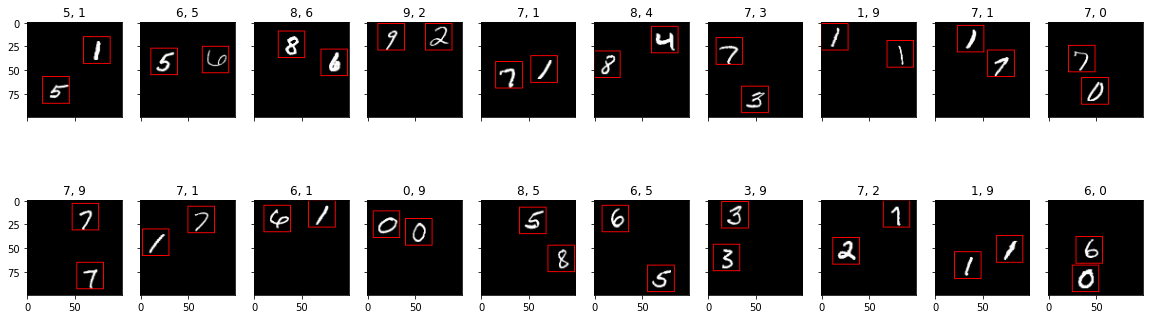

In [ ]:
# Display random digits from both training and validation dataset with predictions and boxes

dataset = train_dataset
batches = 10
batch_size = 2
y = []
train_images = []
train_boxes = []
train_labels = []
for n, ex in enumerate(dataset.unbatch().batch(batch_size).shuffle(5).as_numpy_iterator()):
    if n>=batches:
        break
    train_images.append(ex[0])
    y.append(ex[1])
train_images = np.array(train_images).reshape((batches*batch_size, 100, 100, 1))

for batch in range(batches):
    train_labels.append(y[batch][0])
    train_boxes.append(y[batch][1])
train_boxes = np.array(train_boxes).reshape(batches*batch_size,2, 4)
train_labels = np.array(train_labels).reshape(batches*batch_size, 10)

display_bound_boxes(train_images, train_boxes, train_labels)

In [ ]:
print(train_dataset)

<PrefetchDataset shapes: ((None, 100, 100, 1), ((None, 10), (None, 8))), types: (tf.float32, (tf.float32, tf.float32))>


In [ ]:
# define model

def feature_extractor(inputs):
    x = Conv2D(32, 3, padding = 'same', activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(32, 3, activation='relu', padding = 'same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    return x

def dense_part(inputs):
    x = Flatten()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    return x

def classifier_output(inputs):
    # x = Dense(64, activation = 'relu')(inputs)
    x = Dense(32, activation = 'relu')(inputs)
    output = Dense(10, activation='sigmoid', name = 'Classifier')(x)

    return output

def regressor_output(inputs):
    # x = Dense(128, activation = 'relu')(inputs)
    x = Dense(64, activation = 'relu')(inputs)
    x = Dense(32, activation = 'relu')(x)
    # x = Dense(32, activation = 'relu')(x)
    x = Dense(10, activation = 'relu')(x)
    output = Dense(8, name = 'Regressor')(x)

    return output

# @tf.function
def myModel():
    input = Input(shape = (100, 100, 1))

    extractor_ouptput = feature_extractor(input)
    dense_output = dense_part(extractor_ouptput)
    output1 = classifier_output(dense_output)
    output2 = regressor_output(dense_output)

    model = Model(input, [output1, output2])

    return model


In [ ]:
with strategy.scope():
    model = myModel()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
                loss = {'Classifier' : 'binary_crossentropy',
                        'Regressor' : 'mae'
                        },
                metrics = ['accuracy'])
                #   metrics = {'Classifier' : 'accuracy',
                #              'Regressor' : 'mse'
                #             })

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def print_evaluate():
    train_c_acc = hist.history['Classifier_accuracy']
    train_r_acc = hist.history['Regressor_accuracy']
    train_loss = hist.history['loss']

    valid_c_acc = hist.history['val_Classifier_accuracy']
    valid_r_acc = hist.history['val_Regressor_accuracy']
    valid_loss = hist.history['val_loss']
    epochs = range(len(train_c_acc))

    plt.plot(epochs, train_c_acc, 'r', label = 'Train Classifier Accuracy',)
    plt.plot(epochs, valid_c_acc, 'b', label = 'Validation Classifier Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Classifier Accuracy')
    plt.show()

    plt.plot(epochs, train_r_acc, 'r', label = 'Train Regressor Accuracy',)
    plt.plot(epochs, valid_r_acc, 'b', label = 'Validation Regressor Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Regressor Accuracy')
    plt.show()

    plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
    plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_Regressor_accuracy', min_delta = 0.01, patience=30, verbose = 1, restore_best_weights=True)

In [ ]:
epochs = 500
# steps_per_epoch = 30000//BATCH_SIZE
# val_steps = 5000//BATCH_SIZE

hist = model.fit(train_dataset, epochs = epochs, validation_data= valid_dataset)

Epoch 1/500
59/59 [==============================] - 17s 163ms/step - loss: 1.1619 - Classifier_loss: 0.6669 - Regressor_loss: 0.4950 - Classifier_accuracy: 0.1724 - Regressor_accuracy: 0.0245 - val_loss: 1.0046 - val_Classifier_loss: 0.5226 - val_Regressor_loss: 0.4821 - val_Classifier_accuracy: 0.0638 - val_Regressor_accuracy: 0.0026
Epoch 2/500
59/59 [==============================] - 4s 69ms/step - loss: 0.9906 - Classifier_loss: 0.5148 - Regressor_loss: 0.4758 - Classifier_accuracy: 0.0545 - Regressor_accuracy: 0.0027 - val_loss: 0.9726 - val_Classifier_loss: 0.5067 - val_Regressor_loss: 0.4659 - val_Classifier_accuracy: 0.0692 - val_Regressor_accuracy: 0.0034
Epoch 3/500
59/59 [==============================] - 4s 62ms/step - loss: 0.9662 - Classifier_loss: 0.5023 - Regressor_loss: 0.4639 - Classifier_accuracy: 0.0745 - Regressor_accuracy: 0.0043 - val_loss: 0.9579 - val_Classifier_loss: 0.5000 - val_Regressor_loss: 0.4579 - val_Classifier_accuracy: 0.0882 - val_Regressor_accurac

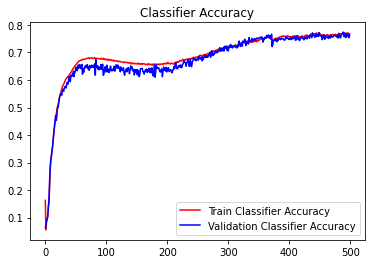

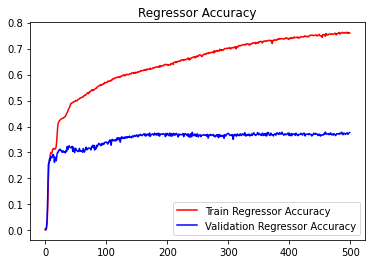

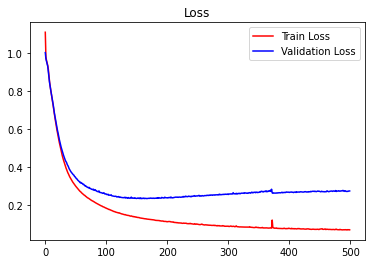

In [ ]:
print_evaluate()

In [ ]:
output = model.evaluate(valid_dataset)

for val in output:
    print(val)

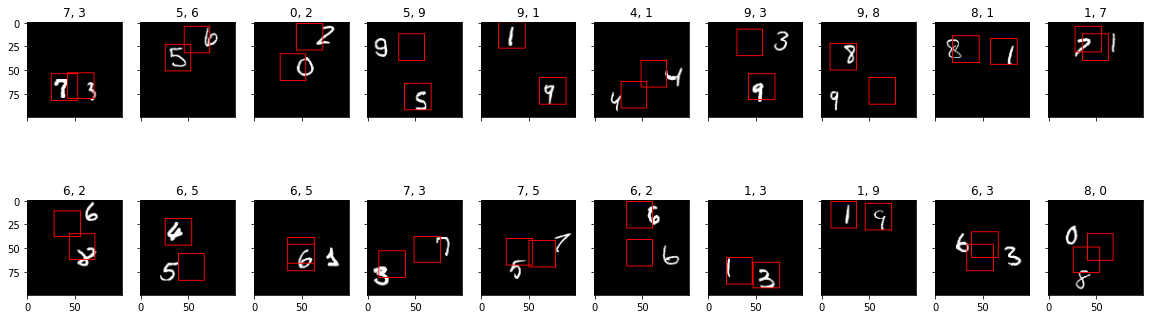

In [ ]:
# Display predictions from validation dataset along with bounding boxes

batches = 10
batch_size = 2
pred = []
test_images = []
test_boxes = []
test_labels = []

for n, ex in enumerate(valid_dataset.unbatch().batch(batch_size).shuffle(100).as_numpy_iterator()):
    if n>=batches:
        break
    pred.append(model.predict([[ex[0]]]))
    test_images.append(ex[0])
test_images = np.array(test_images).reshape((batches*batch_size, 100, 100, 1))


for batch in range(batches):
    test_labels.append(pred[batch][0])
    test_boxes.append(pred[batch][1])
test_boxes = np.array(test_boxes).reshape(batches*batch_size,2, 4)
test_labels = np.array(test_labels).reshape(batches*batch_size, 10)
# Prediction on validation dataset

display_bound_boxes(test_images, test_boxes, test_labels)

In [ ]:
ṅmodel.save('mnist-4-4.h5')